## Week 5 Jupyter Notebook — Support Vector Machines 
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions. 

For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 



Dataset location: https://www.kaggle.com/c/GiveMeSomeCredit/overview

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

In [2]:
#load the Give Me Some Credit training dataset
#dataset can be found here: https://www.kaggle.com/c/GiveMeSomeCredit/overview

file_path = "Give_Me_Some_Credit_cs-training.csv"
df = pd.read_csv(file_path)

In [3]:
#EDA: columns, data types, and summary statistics

#column names, data types
column_info = df.dtypes.reset_index()
column_info.columns = ['Feature', 'Data Type']
print("Col info:\n", column_info.to_string(index=False))

#summary
summary_stats = df.describe().transpose()
print("\nSummary stats\n", summary_stats)


Col info:
                              Feature Data Type
                          Unnamed: 0     int64
                    SeriousDlqin2yrs     int64
RevolvingUtilizationOfUnsecuredLines   float64
                                 age     int64
NumberOfTime30-59DaysPastDueNotWorse     int64
                           DebtRatio   float64
                       MonthlyIncome   float64
     NumberOfOpenCreditLinesAndLoans     int64
             NumberOfTimes90DaysLate     int64
        NumberRealEstateLoansOrLines     int64
NumberOfTime60-89DaysPastDueNotWorse     int64
                  NumberOfDependents   float64

Summary stats
                                          count          mean           std  \
Unnamed: 0                            150000.0  75000.500000  43301.414527   
SeriousDlqin2yrs                      150000.0      0.066840      0.249746   
RevolvingUtilizationOfUnsecuredLines  150000.0      6.048438    249.755371   
age                                   150000.0    

In [4]:
### CLEANING DATA

#create cleaned copy DF for modeling
df_clean = df.copy()

#delete rows where age is 0 or less
df_clean = df_clean[df_clean['age'] > 0]


#set macx "RevolvingUtilizationOfUnsecuredLines" at 1 (100% utilization)
df_clean.loc[df_clean['RevolvingUtilizationOfUnsecuredLines'] > 1, 'RevolvingUtilizationOfUnsecuredLines'] = 1

#set max "MonthlyIncome" at 99th percentile -- doesnt make sense that someone is making over $3 million a MONTH
income_99 = df_clean['MonthlyIncome'].quantile(0.99)
df_clean.loc[df_clean['MonthlyIncome'] > income_99, 'MonthlyIncome'] = income_99

#reset index, confirm changes
df_clean.reset_index(drop=True, inplace=True)

#review changes AFTER cleaning
cleaning_summary = {
    "Remaining Rows": len(df_clean),
    "Max Age": df_clean["age"].max(),
    "Min Age": df_clean["age"].min(),
    "Max Utilization": df_clean["RevolvingUtilizationOfUnsecuredLines"].max(),
    "99th Percentile MonthlyIncome Cap": income_99,
    "Max MonthlyIncome (After Cap)": df_clean["MonthlyIncome"].max()
}
pd.DataFrame.from_dict(cleaning_summary, orient='index', columns=['Value'])


,Value
Remaining Rows,149999.0
Max Age,109.0
Min Age,21.0
Max Utilization,1.0
99th Percentile MonthlyIncome Cap,25000.0
Max MonthlyIncome (After Cap),25000.0


In [5]:
#age is currently a max of 109, which seems unlikely that they would be applying for a mortgage
#will cap at 95 

df_clean.loc[df_clean['age'] > 95, 'age'] = 95

# Confirm the change
df_clean['age'].describe()


count    149999.000000
mean         52.294095
std          14.766768
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max          95.000000
Name: age, dtype: float64

In [6]:
#review changes AFTER cleaning
cleaning_summary = {
    "Remaining Rows": len(df_clean),
    "Max Age": df_clean["age"].max(),
    "Min Age": df_clean["age"].min(),
    "Max Utilization": df_clean["RevolvingUtilizationOfUnsecuredLines"].max(),
    "99th Percentile MonthlyIncome Cap": income_99,
    "Max MonthlyIncome (After Cap)": df_clean["MonthlyIncome"].max()
}
pd.DataFrame.from_dict(cleaning_summary, orient='index', columns=['Value'])

,Value
Remaining Rows,149999.0
Max Age,95.0
Min Age,21.0
Max Utilization,1.0
99th Percentile MonthlyIncome Cap,25000.0
Max MonthlyIncome (After Cap),25000.0


In [7]:
### TRAIN 

#received error message "ValueError: Input X contains NaN.
# LinearSVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively."
#need to ensure that no NAN values are used
df_clean = df_clean.fillna(df_clean.mean())

#separate features/ target from cleaned dataset
X_clean = df_clean.drop("SeriousDlqin2yrs", axis=1)
y_clean = df_clean["SeriousDlqin2yrs"]




#scale features
scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_clean)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_clean, y_clean, test_size=0.25, random_state=42, stratify=y_clean
)

#train Linear SVM
linear_svm = LinearSVC(C=1.0, max_iter=5000)
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)
linear_report = classification_report(y_test, y_pred_linear, output_dict=True)

#train RBF SVM
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
rbf_report = classification_report(y_test, y_pred_rbf, output_dict=True)

#results
linear_results_df = pd.DataFrame(linear_report).transpose()
rbf_results_df = pd.DataFrame(rbf_report).transpose()

linear_results_df, rbf_results_df

(              precision    recall  f1-score       support
 0              0.934374  0.998885  0.965553  34993.000000
 1              0.571429  0.020742  0.040031   2507.000000
 accuracy       0.933493  0.933493  0.933493      0.933493
 macro avg      0.752901  0.509814  0.502792  37500.000000
 weighted avg   0.910110  0.933493  0.903679  37500.000000,
               precision    recall  f1-score       support
 0              0.936702  0.998028  0.966393  34993.000000
 1              0.680556  0.058636  0.107969   2507.000000
 accuracy       0.935227  0.935227  0.935227      0.935227
 macro avg      0.808629  0.528332  0.537181  37500.000000
 weighted avg   0.919578  0.935227  0.909005  37500.000000)

# Review of approach for Week 5 / Notes / Observations 

##  Linear vs. RBF SVM models

I compared a baseline Linear Support Vector Machine (LinearSVC) to a nonlinear RBF kernel SVM (SVC(kernel='rbf')) using the cleaned credit dataset. Output:

| Type | Linear SVM | RBF SVM |
|--------|------------|---------|
| Default Precision (Class 1) | 0.571 | **0.681** |
| Default Recall (Class 1)    | 0.021 | **0.059** |
| Default F1-score (Class 1)  | 0.040 | **0.108** |
| Accuracy                    | 93.3% | **93.5%** |

- RBF SVM outperformed Linear SVM on all metrics related to default prediction (class 1).
- Both models performed well on class 0 (where it is non-default), but RBF was slightly better at detecting actual defaults, which is more important in finance. .
- Accuracy was not a meaningful metric on its own due to class imbalance. Because of this I prioritized precision, recall, and F1-score for defaults.

The RBF kernel improved model performance for identifying risky borrowers. This indicates that nonlinear patterns exist in the relationship between borrower features and default risk.
The recall values appear low overall, but it is important to note that even small improvements in identifying high-risk borrowers (from 2.1% to 5.9%) are important in financial risk modeling; they allow for earlier intervention and risk mitigation strategies.


##  EDA improved the Model

EDA helped with: 

- Outliers and invalid values in features like age (minimum 0, maximum 109), MonthlyIncome (up to $3 million), and RevolvingUtilizationOfUnsecuredLinesn (> 50,000).
- I capped or removed these values to ensure SVM models would not be distorted during margin computation.
- EDA also revealed the class imbalance** problem early, which informed my decision to focus on F1-score and recall instead of accuracy.


##  Overfitting

I applied the following to avoid overfitting the model:

- Feature scaling: I used StandardScaler to normalize all numeric input features. This prevents certain features from dominating due to scale (important for distance-based models like SVM).
- Regularization via the C parameter: I used a moderate value of C = 1.0 to balance margin width and classification accuracy. Lower values (C) allow for more margin errors, reducing overfitting.
- Train/test split: I reserved 25% of the dataset for testing, ensuring that model performance was evaluated on unseen data.
- Capping outliers: I capped MonthlyIncome at the 99th percentile, age at 95, and RevolvingUtilizationOfUnsecuredLines at 1.0. These caps helped reduce the influence of extreme values that can cause overfitting.
- These improved generalizability and stabilized training, which helped a lot for the RBF kernel SVM.


## Metrics and Tuning

Performance of the model was evaluated: 

- F1-score: best for imbalanced data (which I have); it balances precision and recall.
- Precision and Recall for Class 1 (defaults): Since defaults are rare but important, high recall ensures I catch more true defaulters; precision ensures I don’t label too many good borrowers as bad.
- Accuracy: noted, but not prioritized due to the class imbalance.
- At this stage, I used default values for C and gamma. 


## Expected / Unexpected Results

Expected:
- The RBF kernel SVM performed better than linear SVM, which aligns with my thought that borrower behavior may follow nonlinear patterns.
- Precision was higher than recall in both models, which is expected in default modeling due to class imbalance.

Unexpected:
- The recall for defaults is still very low (<6%); even with the RBF kernel. This may show that nonlinear decision boundaries may be struggling to separate defaults clearly (maybe because of feature overlap or missing variables).


##  External Sources

For Support Vector Machines, I reviewed the following resources from YellowDig:

- https://www.ibm.com/think/topics/support-vector-machine
- https://web.mit.edu/6.034/wwwbob/svm.pdf
- https://www.geeksforgeeks.org/machine-learning/support-vector-machine-algorithm/
- https://www.kaggle.com/discussions/getting-started/161325



## Issues I ran into
- Multiple Kernal restarts, which resulted in me having to retrain the models multuple times. 
- Missing values causing model errors (received NaN errors). I ionitially tried training LinearSVC, but received a ValueError: Input X contains NaN (this was because fillna() was applied after splitting X and y)
- Extreme outliers, like age over 100. 

<Figure size 600x400 with 0 Axes>

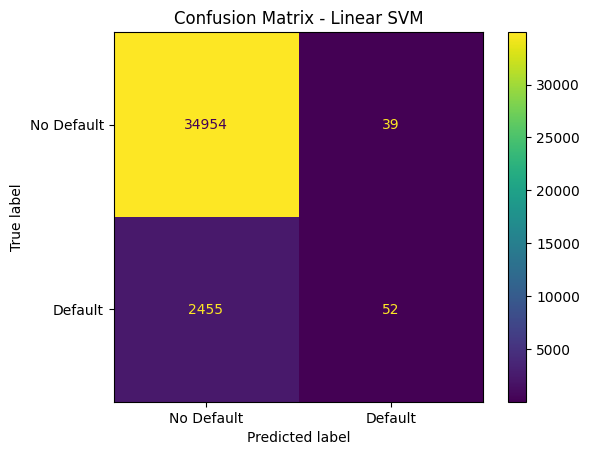

<Figure size 600x400 with 0 Axes>

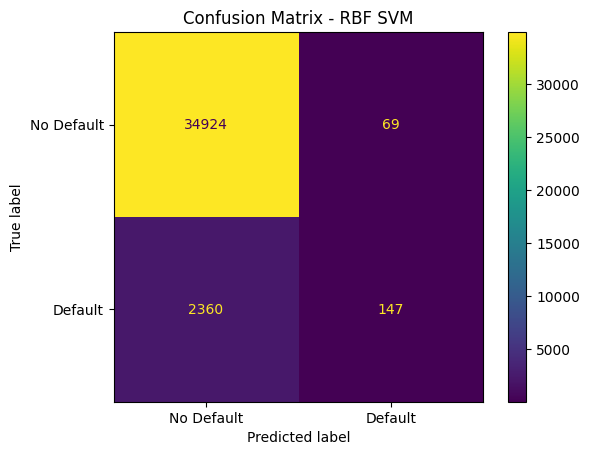

In [8]:
##  GRAPH / conslusion
#  Re-train the models after kernel restart

#re-split the cleaned and scaled dataset
X_clean = df_clean.drop("SeriousDlqin2yrs", axis=1)
y_clean = df_clean["SeriousDlqin2yrs"]
scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_clean)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_clean, y_clean, test_size=0.25, random_state=42, stratify=y_clean
)

#rRe-train the models
linear_svm = LinearSVC(C=1.0, max_iter=5000)
linear_svm.fit(X_train, y_train)

rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
rbf_svm.fit(X_train, y_train)

#make predictions
y_pred_linear = linear_svm.predict(X_test)
y_pred_rbf = rbf_svm.predict(X_test)

#generate/ display confusion matrices
cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

#plot Linear SVM confusion matrix
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay(cm_linear, display_labels=["No Default", "Default"]).plot(values_format='d')
plt.title("Confusion Matrix - Linear SVM")
plt.grid(False)
plt.show()

#\plot RBF SVM confusion matrix
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay(cm_rbf, display_labels=["No Default", "Default"]).plot(values_format='d')
plt.title("Confusion Matrix - RBF SVM")
plt.grid(False)
plt.show()

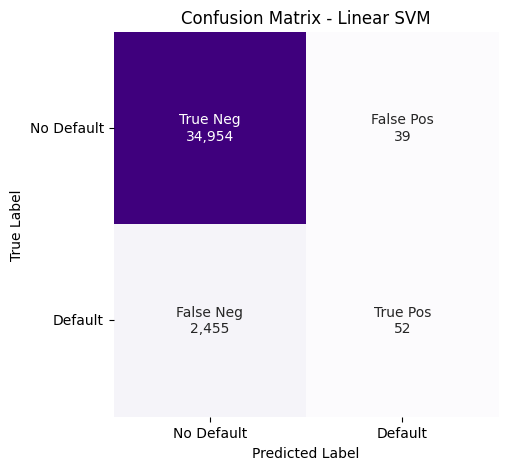

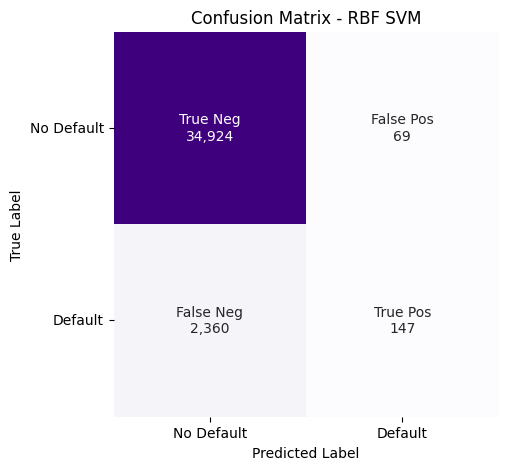

In [10]:
## recreated matrix so it is easier to read
#recalc confusion matrices
cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

labels = np.array([["True Neg", "False Pos"], ["False Neg", "True Pos"]])
group_counts_linear = ["{:,}".format(value) for value in cm_linear.flatten()]
group_counts_rbf = ["{:,}".format(value) for value in cm_rbf.flatten()]

grouped_labels_linear = [f"{label}\n{count}" for label, count in zip(labels.flatten(), group_counts_linear)]
grouped_labels_rbf = [f"{label}\n{count}" for label, count in zip(labels.flatten(), group_counts_rbf)]

#reshape to 2x2 matrix
grouped_labels_linear = np.asarray(grouped_labels_linear).reshape(2, 2)
grouped_labels_rbf = np.asarray(grouped_labels_rbf).reshape(2, 2)

#plot Linear SVM
plt.figure(figsize=(6, 5))
sns.heatmap(cm_linear, annot=grouped_labels_linear, fmt="", cmap="Purples", cbar=False, square=True)
plt.title("Confusion Matrix - Linear SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No Default", "Default"])
plt.yticks([0.5, 1.5], ["No Default", "Default"], rotation=0)
plt.show()

#plot RBF SVM
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rbf, annot=grouped_labels_rbf, fmt="", cmap="Purples", cbar=False, square=True)
plt.title("Confusion Matrix - RBF SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No Default", "Default"])
plt.yticks([0.5, 1.5], ["No Default", "Default"], rotation=0)
plt.show()
